In [1]:
# %load src/header.py
'''LOAD'''
#%load /Users/rokushou/Desktop/header.py
'''GENERAL'''
import os
#import time
#import timeit
#import warnings
#warnings.simplefilter('ignore')
#import glob
#import random
#import collections
import secrets
import math
import itertools
import pickle
'''DATA'''
import numpy as np
import pandas as pd
import pandas_profiling
#import databricks.koalas as ks
'''DATABASES'''
#from pymongo import MongoClient
from pyspark.sql import SparkSession
'''PLOT'''
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
font = {'size':16}
#import seaborn as sns
'''SCIPY/STATS'''
#import scipy.stats as scs
#from scipy.optimize import nnls
#import statsmodels.api as sm
#import pymc3 as pm
'''SCIKIT LEARN'''
#from sklearn.datasets import make_classification, load_iris, load_boston, load_digits
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import PolynomialFeatures, StandardScaler
#from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, cross_val_score, GridSearchCV, cross_val_predict
#from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer
#from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
#from sklearn.linear_model import LinearRegression, LogisticRegression
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier
#from sklearn.decomposition import PCA, NMF
#from sklearn.cluster import KMeans
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#import skimage
'''TENSORFLOW'''
#import tensorflow as tf
'''NLTK'''
#import nltk
#import unicodedata
#import string
#from nltk.corpus import stopwords
#from nltk.tokenize import sent_tokenize, word_tokenize
#from nltk.stem.porter import PorterStemmer
#from nltk.stem.snowball import SnowballStemmer
#from nltk.stem.wordnet import WordNetLemmatizer
'''NETWORK'''
#import networkx as nx
#import nxpd
#import community as comm
'''FUNCTIONS'''
nrange = lambda x : itertools.repeat(None, x)
def argmaxEX(a, n=1, reverse=False):
    '''
    Similar to argmax but returns the indices of the n highest values from array a.
    Uses argpartition for efficiency.

    Inputs
        a (array): 1 dimensional numpy array
        n (int): the number of indices to return
        reverse (bool): return indices of lowest values instead, becomes argminEX

    Output
        list: list of indices
    '''
    import numpy as np
    if not reverse:
        a = -a
    if a.shape[0] < n*np.log10(n)/(n-1):
        return np.argpartition(a, range(n))[:n]
    sort = np.argpartition(a, n)[:n]
    return sort[np.argsort(a[sort])]
'''PALETTE'''
t = secrets.token_hex(8)
qan = {t:'#8DE5A1'} # GN green
twi = '#DCB8E7' # Pale, light grayish mulberry
twi_blu = '#273873' # Dark sapphire blue
twi_pur = '#662D8A' # Moderate purple
twi_pnk = '#ED438D' # Brilliant raspberry
'''SIGNATURE'''
!fortune | cowsay -f dragon
#os.system('fortune | cowsay -f dragon')

from src.recommender import ItemRecommender

 _________________________________________ 
/ Carperpetuation (kar' pur pet u a       \
| shun), n.:                              |
|                                         |
| The act, when vacuuming, of running     |
| over a string at least a                |
|                                         |
| dozen times, reaching over and picking  |
| it up, examining it, then               |
|                                         |
| putting it back down to give the vacuum |
| one more chance.                        |
|                                         |
\ -- Rich Hall, "Sniglets"                /
 ----------------------------------------- 
      \                    / \  //\
       \    |\___/|      /   \//  \\
            /0  0  \__  /    //  | \ \    
           /     /  \/_/    //   |  \  \  
           @_^_@'/   \/_   //    |   \   \ 
           //_^_/     \/_ //     |    \    \
        ( //) |        \///      |     \     \
      ( / /) _|_ /   )  //       |      \    

## Narrowing the scope
In order to create the ranking system for my recommeder I need to use aggregate data from only the most relavant matches.

I can actually use the data I previously cleaned for my failed modeling with metadata section.

In [2]:
df = pd.read_pickle('data/by_player_clean.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13092121 entries, 0 to 15623
Data columns (total 10 columns):
match         int64
game-ver      object
lobby-mode    object
lobby         object
mode          object
stage         object
weapon        object
rank          object
level         float64
win           bool
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 1011.3+ MB


### Narrowing by game version

Each new patch brings with it a slew of balance patches which changes weapon performance. I want only the most recent data but also over a long enough period that spikes are evened out.

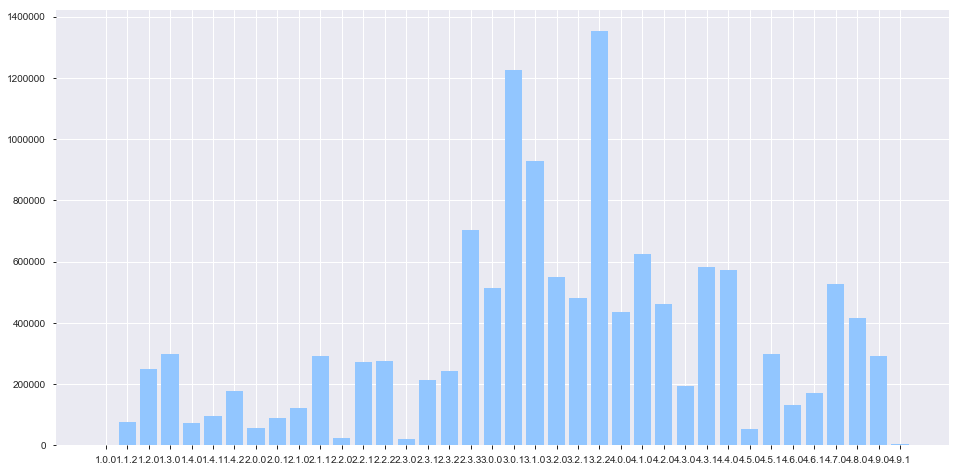

In [3]:
# look at how many entries from each game version (patch)
ver_count = df['game-ver'].value_counts(sort=False).sort_index()
plt.figure(figsize=(16, 8))
plt.bar(ver_count.index, ver_count);

I chose the cutoff at 4.0.0 (September 14 2018) due to domain knowledge of the game's workings. It also provides a good sample size that reaches back close to a year. 

In [4]:
# select only the verions I want
versions = sorted(df['game-ver'].unique().tolist(), reverse=True)
versions[:14]

['4.9.1',
 '4.9.0',
 '4.8.0',
 '4.7.0',
 '4.6.1',
 '4.6.0',
 '4.5.1',
 '4.5.0',
 '4.4.0',
 '4.3.1',
 '4.3.0',
 '4.2.0',
 '4.1.0',
 '4.0.0']

In [5]:
# index by above versions
df = df[df['game-ver'].isin(versions[:14])]
# check results
df['game-ver'].value_counts(sort=False).sort_index()

4.0.0    434672
4.1.0    626203
4.2.0    460680
4.3.0    193891
4.3.1    582665
4.4.0    573742
4.5.0     51881
4.5.1    297644
4.6.0    130145
4.6.1    169895
4.7.0    527219
4.8.0    416206
4.9.0    290898
4.9.1      4267
Name: game-ver, dtype: int64

### Narrowing by rank

In order to assure my recommender properly judges weapon performance, I want to use data from only high-level play and prevent new or casual players from skewing the results.

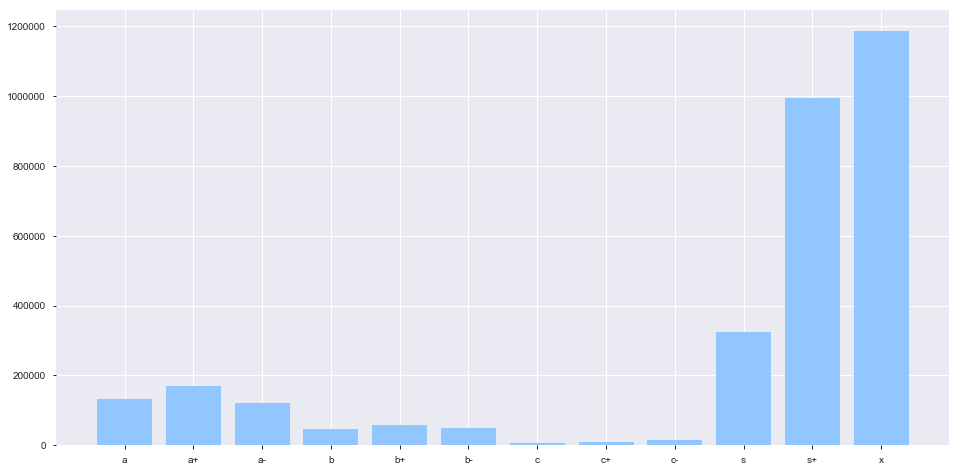

In [6]:
# look at how many entries from each rank
rank_count = df['rank'].value_counts(sort=False).sort_index()
plt.figure(figsize=(16, 8))
plt.bar(rank_count.index, rank_count);

Fortunately, most of the entries are from rank S and above, which is aproximately the top 10% of players. I also want to keep the NAs because those are from Turf War mode which is unranked.

In [7]:
df['rank'].value_counts(sort=False, dropna=False)

NaN    1642587
x      1186427
s+      993502
b+       58416
a       133655
c         6409
c-       15144
a-      121078
a+      170684
s       325091
b        46466
c+        9700
b-       50849
Name: rank, dtype: int64

In [8]:
# select only the ranks I want
ranks = df['rank'].unique().tolist()
ranks[:3]

['s+', 's', 'x']

In [9]:
# index by selected ranks
df = df[df['rank'].isin(ranks[:3]) | (df['rank'].isnull())]
df['rank'].value_counts(sort=False)

x     1186427
s+     993502
s      325091
Name: rank, dtype: int64

In [10]:
# check if NAs were preserved
np.sum(df.isnull())

match               0
game-ver            0
lobby-mode          0
lobby               0
mode                0
stage               0
weapon              0
rank          1642587
level               0
win                 0
dtype: int64

## Aggregation

Since I will be doing an item to item recommender, I need to aggregate data for each of the weapons (items).

I want to split by mode first since weapons perform dfferently in each mode.

In [11]:
# group by mode and check ordering
gb = df.groupby(['mode'])
df.groupby(['mode']).first()

,match,game-ver,lobby-mode,lobby,stage,weapon,rank,level,win
mode,,,,,,,,,
area,0,4.2.0,gachi,standard,gangaze,nova_becchu,s+,140.0,False
asari,7,4.2.0,gachi,standard,mutsugoro,ochiba,s+,188.0,True
hoko,2,4.2.0,gachi,standard,devon,heroroller_replica,s,146.0,True
nawabari,53,4.2.0,regular,standard,sumeshi,nzap85,NaN,63.0,False
yagura,8,4.2.0,gachi,standard,otoro,hotblaster,s+,40.0,False


In [12]:
# split groupby into separate dataframes contained in a list
modes  = [gb.get_group(x) for x in gb.groups]

In [13]:
# testing aggregating for usage
df.groupby('weapon').match.count().head()

weapon
52gal            9915
52gal_becchu    18584
52gal_deco       9701
96gal           19131
96gal_deco      23979
Name: match, dtype: int64

In [14]:
# testing aggregating for win rate
df.groupby('weapon').win.mean().head()

weapon
52gal           0.475139
52gal_becchu    0.493597
52gal_deco      0.471910
96gal           0.513408
96gal_deco      0.517369
Name: win, dtype: float64

In [15]:
# initialize dataframe with weapon names in correct order
score = pd.DataFrame()
score['key'] = list(df.groupby('weapon').groups.keys())
score.head()

,key
0,52gal
1,52gal_becchu
2,52gal_deco
3,96gal
4,96gal_deco


In [16]:
# fill new dataframe with usage and win rate
for name, data in zip(['Splat Zones', 'Clam Blitz', 'Rainmaker', 'Turf War', 'Tower Control'], modes):
#     score[name + '_usage'] = data.groupby('weapon').match.count().values
    score[name + '_winrate'] = data.groupby('weapon').win.mean().values
score.head()

,key,Splat Zones_winrate,Clam Blitz_winrate,Rainmaker_winrate,Turf War_winrate,Tower Control_winrate
0,52gal,0.439716,0.497638,0.461300,0.480213,0.497850
1,52gal_becchu,0.479037,0.509861,0.493407,0.499650,0.485860
2,52gal_deco,0.452133,0.475052,0.490795,0.469601,0.457627
3,96gal,0.511498,0.534125,0.497249,0.514590,0.514706
4,96gal_deco,0.512068,0.510252,0.500387,0.537533,0.508188


Load the weapon metadata and join to get english names of the weapons.

In [17]:
# load only the keys and english names
names = pd.read_csv('data/weapon.csv')[['key', '[en-US]']]
# merge on key
score = score.merge(names, 'left', 'key')
# replace key with english name
score['key'] = score['[en-US]']
score.drop('[en-US]', axis=1, inplace=True)
score.head()

,key,Splat Zones_winrate,Clam Blitz_winrate,Rainmaker_winrate,Turf War_winrate,Tower Control_winrate
0,.52 Gal,0.439716,0.497638,0.461300,0.480213,0.497850
1,Kensa .52 Gal,0.479037,0.509861,0.493407,0.499650,0.485860
2,.52 Gal Deco,0.452133,0.475052,0.490795,0.469601,0.457627
3,.96 Gal,0.511498,0.534125,0.497249,0.514590,0.514706
4,.96 Gal Deco,0.512068,0.510252,0.500387,0.537533,0.508188


In [18]:
# Save to pickle
score.to_pickle('data/weapon_winrate.pkl')

## Item to Item similarity based recommender

First I load the weapon metadata

In [19]:
weapons = pd.read_csv('data/weapon.csv')
weapons.head()

,category1,category2,key,subweapon,special,mainweapon,reskin,splatnet,[de-DE],[en-GB],[en-US],[es-ES],[es-MX],[fr-CA],[fr-FR],[it-IT],[ja-JP],[ja-JP@calendar=japanese],[nl-NL],[ru-RU]
0,shooter,shooter,52gal,pointsensor,sphere,52gal,52gal,50,.52 Gallon,.52 Gal,.52 Gal,Salpicadora 2000,Salpicadora 2000,Calibre 2000,Calibre 2000,Calibro 2000,.52ガロン,.52ガロン,.52 Kaliter,Струевик .52
1,shooter,shooter,52gal_deco,curlingbomb,presser,52gal,52gal_deco,51,.52 Gallon Deko,.52 Gal Deco,.52 Gal Deco,Salpicadora 2000 DX,Salpicadora 2000 chic,Calibre 2000 chic,Calibre 2000 chic,Calibro 2000 DX,.52ガロンデコ,.52ガロンデコ,.52 Kaliter Deco,Струевик .52 «Деко»
2,shooter,shooter,96gal,sprinkler,armor,96gal,96gal,80,.96 Gallon,.96 Gal,.96 Gal,Salpicadora 3000,Salpicadora 3000,Calibre 3000,Calibre 3000,Calibro 3000,.96ガロン,.96ガロン,.96 Kaliter,Струевик .96
3,shooter,shooter,96gal_deco,splashshield,chakuchi,96gal,96gal_deco,81,.96 Gallon Deko,.96 Gal Deco,.96 Gal Deco,Salpicadora 3000 DX,Salpicadora 3000 chic,Calibre 3000 chic,Calibre 3000 chic,Calibro 3000 DX,.96ガロンデコ,.96ガロンデコ,.96 Kaliter Deco,Струевик .96 «Деко»
4,shooter,shooter,promodeler_mg,kyubanbomb,curlingbomb_pitcher,promodeler_mg,promodeler_mg,30,Airbrush MG,Aerospray MG,Aerospray MG,Aerógrafo pro,Aerógrafo GP,Pouche-pouche,Aérogun,Aerografo,プロモデラーMG,プロモデラーMG,Kladderwerper,Аэроспрей


In [20]:
weapons.columns

Index(['category1', 'category2', 'key', 'subweapon', 'special', 'mainweapon',
       'reskin', 'splatnet', '[de-DE]', '[en-GB]', '[en-US]', '[es-ES]',
       '[es-MX]', '[fr-CA]', '[fr-FR]', '[it-IT]', '[ja-JP]',
       '[ja-JP@calendar=japanese]', '[nl-NL]', '[ru-RU]'],
      dtype='object')

There are many columns like the languages that are useless to me.

In [21]:
# set english names as key
weapons['key'] = weapons['[en-US]']
# select collumns
weapons = weapons[['key', 'category1', 'category2', 'subweapon', 'special', 'mainweapon']]
weapons.head()

,key,category1,category2,subweapon,special,mainweapon
0,.52 Gal,shooter,shooter,pointsensor,sphere,52gal
1,.52 Gal Deco,shooter,shooter,curlingbomb,presser,52gal
2,.96 Gal,shooter,shooter,sprinkler,armor,96gal
3,.96 Gal Deco,shooter,shooter,splashshield,chakuchi,96gal
4,Aerospray MG,shooter,shooter,kyubanbomb,curlingbomb_pitcher,promodeler_mg


Get dummies for all the categorical features in order to feed it to my recommender.

In [22]:
weapons = pd.get_dummies(data = weapons, columns=['category1', 'category2', 'subweapon', 'special', 'mainweapon'])
weapons = weapons.set_index('key')
weapons.head()

,category1_brella,category1_charger,category1_roller,category1_shooter,category1_slosher,category1_splatling,category2_blaster,category2_brella,category2_brush,category2_charger,...,mainweapon_soytuber,mainweapon_splatcharger,mainweapon_splatroller,mainweapon_splatspinner,mainweapon_sputtery,mainweapon_spygadget,mainweapon_squiclean_a,mainweapon_sshooter,mainweapon_variableroller,mainweapon_wakaba
key,,,,,,,,,,,,,,,,,,,,,
.52 Gal,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.52 Gal Deco,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.96 Gal,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.96 Gal Deco,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aerospray MG,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Pickle dataframe for model depolyment on website.

In [23]:
weapons.to_pickle('data/weapon_features.pkl')

Create and test the recommender.

In [24]:
model = ItemRecommender()
# the recommender uses the DF index for the item names
model.fit(weapons)

I will test various methods to make sure it is working, but only get_weapon_recommendation is meant for the end product.

In [25]:
# unscored recommendation using 1 entry
model.get_recommendations('Forge Splattershot Pro')

array(['Kensa Splattershot Pro', 'Kensa Splattershot Jr.',
       'Kensa Splattershot', 'Aerospray MG', 'Splattershot Pro'],
      dtype=object)

In [26]:
# unscored recommendation using multiple entries
model.get_user_recommendation(['Forge Splattershot Pro', 'Splattershot Jr.'])

array(["N-ZAP '85", 'Kensa Splattershot Pro', 'Kensa Splattershot Jr.',
       'Foil Squeezer', 'Sploosh-o-matic 7'], dtype=object)

In [27]:
# scored recommendation using one or more entries
model.get_weapon_recommendation(['Forge Splattershot Pro', 'Splattershot Jr.'])

Try the Sploosh-o-matic 7 for a 2.42% win rate increase in Turf War!


In [28]:
with open('data/model.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(model, f)

## Ensemble modeling

First I pick the 10 weapons closest to the user selection(s) then I rank them by their win rate for the game mode. This was originally created as a standalone function but got encorporated into the ItemRecommender model for portability.

In [29]:
def rec_weapon(weapon, modes='Turf War'):
    
    # data assignement shenanigans
    if type(weapon) == str:
        weapon = [weapon]
    if modes == 'debug':
        modes = ['Turf War', 'Splat Zones', 'Tower Control', 'Rainmaker', 'Clam Blitz']
    elif type(modes) == str:
        modes = [modes]
    
    # loop through every mode
    for mode in modes:
        # get predictions
        recs = model.get_user_recommendation(weapon, 10)
        # take predictions from scored list and sort by winrate
        recs = score[score.key.isin(recs)].sort_values(mode + '_winrate', ascending=False)
        # get the name of the highest winrate weapon
        best = recs.key.iloc[0]

        # calculate % winrate increase
        current = score[score.key.isin(weapon)].sort_values(mode + '_winrate', ascending=False).iloc[0]
        new = float(recs[mode + '_winrate'].iloc[0])
        percent = (new - float(current[mode + '_winrate'])) * 100

        # only make a recommendation if it is an improvement
        if percent <= 0:
            print ('The {} is already a great choice for {}!'.format(current['key'], mode))
        else:
            print('Try the {} for a {:.2f}% win rate increase in {}!'.format(best, percent, mode))

In [30]:
rec_weapon(['Undercover Brella', 'Custom Dualie Squelchers', 'Enperry Splat Dualies'], 'debug')

The Custom Dualie Squelchers is already a great choice for Turf War!
Try the Dark Tetra Dualies for a 1.26% win rate increase in Splat Zones!
Try the Kensa Splat Dualies for a 2.16% win rate increase in Tower Control!
Try the Kensa Splat Dualies for a 0.61% win rate increase in Rainmaker!
The Enperry Splat Dualies is already a great choice for Clam Blitz!
